In [1]:
import numpy as np
import pandas as pd

import string
import importlib

import russia_df_utils
importlib.reload(russia_df_utils)
from russia_df_utils import get_uncategorized_df_rows

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim import corpora, models, similarities, matutils
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import NMF
from sklearn.metrics import silhouette_score


import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
sns.set()

%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.tokenizer = TweetTokenizer(preserve_case=False)
    def __call__(self, doc):
        tokens = self.tokenizer.tokenize(doc)
        tokens = [word for word in tokens if word.isalpha()]
        return [self.wnl.lemmatize(t) for t in tokens]


In [3]:
clustered_tweets = get_uncategorized_df_rows(drop_retweets=True)
clustering_text = clustered_tweets['processed_text']

In [4]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('all')
tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=10)
vectorized_tweets = tfidf.fit_transform(clustering_text.values)

#pd.DataFrame(vectorized_tweets.todense(), 
#             columns=tfidf.get_feature_names()
#            ).head()

tfidf_corpus = matutils.Sparse2Corpus(vectorized_tweets.transpose())

# Row indices
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())

# This is a hack for Python 3!
id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                         id2word=id2word)




2018-03-07 03:57:19,774 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-07 03:57:19,850 : INFO : adding document #10000 to Dictionary(0 unique tokens: [])
2018-03-07 03:57:19,966 : INFO : adding document #20000 to Dictionary(0 unique tokens: [])
2018-03-07 03:57:20,104 : INFO : adding document #30000 to Dictionary(0 unique tokens: [])
2018-03-07 03:57:20,234 : INFO : adding document #40000 to Dictionary(0 unique tokens: [])
2018-03-07 03:57:20,365 : INFO : adding document #50000 to Dictionary(0 unique tokens: [])
2018-03-07 03:57:20,441 : INFO : built Dictionary(6658 unique tokens: ['rather provide', 'pin', 'hanging', 'disappointed', 'milwaukeevoice']...) from 51867 documents (total 121203 corpus positions)


In [5]:
lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=300, power_iters=10)


2018-03-07 03:57:20,448 : INFO : using serial LSI version on this node
2018-03-07 03:57:20,449 : INFO : updating model with new documents
2018-03-07 03:57:20,557 : INFO : preparing a new chunk of documents
2018-03-07 03:57:20,644 : INFO : using 100 extra samples and 10 power iterations
2018-03-07 03:57:20,644 : INFO : 1st phase: constructing (6658, 400) action matrix
2018-03-07 03:57:21,196 : INFO : orthonormalizing (6658, 400) action matrix
2018-03-07 03:57:27,404 : INFO : 2nd phase: running dense svd on (400, 20000) matrix
2018-03-07 03:57:30,804 : INFO : computing the final decomposition
2018-03-07 03:57:30,820 : INFO : keeping 300 factors (discarding 14.767% of energy spectrum)
2018-03-07 03:57:30,880 : INFO : processed documents up to #20000
2018-03-07 03:57:30,886 : INFO : topic #0(12.276): 0.645*"realdonaldtrump" + 0.457*"hillaryclinton" + 0.348*"politics" + 0.116*"obama" + 0.108*"news" + 0.105*"not" + 0.091*"campaign" + 0.088*"says" + 0.077*"people" + 0.073*"hillaryclinton real

In [7]:
lsi.print_topics()

2018-03-07 01:33:18,951 : INFO : topic #0(19.859): 0.663*"realdonaldtrump" + 0.450*"hillaryclinton" + 0.341*"politics" + 0.110*"news" + 0.108*"not" + 0.107*"obama" + 0.090*"campaign" + 0.083*"says" + 0.071*"people" + 0.071*"hillaryclinton realdonaldtrump"
2018-03-07 01:33:18,955 : INFO : topic #1(14.261): 0.468*"not" + -0.448*"realdonaldtrump" + 0.278*"hillaryclinton" + 0.218*"all" + 0.209*"people" + -0.187*"politics" + 0.163*"like" + 0.146*"love" + 0.120*"islamkills" + 0.115*"know"
2018-03-07 01:33:18,956 : INFO : topic #2(14.043): -0.744*"hillaryclinton" + 0.393*"realdonaldtrump" + 0.289*"not" + 0.130*"people" + 0.122*"all" + -0.105*"politics" + 0.103*"love" + 0.085*"like" + 0.073*"islamkills" + -0.066*"bill"
2018-03-07 01:33:18,957 : INFO : topic #3(12.787): -0.693*"trumpforpresident" + -0.396*"hillaryforprison2016" + -0.267*"hillaryforprison2016 trumpforpresident" + 0.266*"not" + 0.231*"politics" + 0.119*"obama" + -0.117*"maga" + -0.110*"vote" + -0.110*"trumppence16" + -0.097*"trum

[(0,
  '0.663*"realdonaldtrump" + 0.450*"hillaryclinton" + 0.341*"politics" + 0.110*"news" + 0.108*"not" + 0.107*"obama" + 0.090*"campaign" + 0.083*"says" + 0.071*"people" + 0.071*"hillaryclinton realdonaldtrump"'),
 (1,
  '0.468*"not" + -0.448*"realdonaldtrump" + 0.278*"hillaryclinton" + 0.218*"all" + 0.209*"people" + -0.187*"politics" + 0.163*"like" + 0.146*"love" + 0.120*"islamkills" + 0.115*"know"'),
 (2,
  '-0.744*"hillaryclinton" + 0.393*"realdonaldtrump" + 0.289*"not" + 0.130*"people" + 0.122*"all" + -0.105*"politics" + 0.103*"love" + 0.085*"like" + 0.073*"islamkills" + -0.066*"bill"'),
 (3,
  '-0.693*"trumpforpresident" + -0.396*"hillaryforprison2016" + -0.267*"hillaryforprison2016 trumpforpresident" + 0.266*"not" + 0.231*"politics" + 0.119*"obama" + -0.117*"maga" + -0.110*"vote" + -0.110*"trumppence16" + -0.097*"trump2k16"'),
 (4,
  '0.712*"not" + -0.440*"love" + -0.189*"like" + -0.174*"people" + -0.168*"all" + 0.167*"trumpforpresident" + -0.123*"obama" + -0.101*"one" + 0.100*

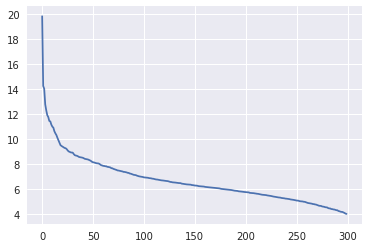

In [8]:
plt.plot(lsi.projection.s)

In [6]:
# Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn)
lsi_corpus = lsi[tfidf_corpus]

# Dump the resulting document vectors into a list so we can take a look
doc_vecs = [doc for doc in lsi_corpus]
ng_lsi = matutils.corpus2dense(lsi_corpus, num_terms=300).transpose()


In [7]:
SSEs = []
k_range = range(3,100)
for k in k_range:
    print('KM with {} clusters.'.format(k))
    model = KMeans(n_clusters=k)
    model.fit(ng_lsi)
    labels = model.labels_
    clustered_tweets['cluster_k{}'.format(k)] = labels
    clustered_tweets.to_csv('../csvs/km_lsa_300.csv')
    #Sil_coefs.append(silhouette_score(vectorized_tweets, labels, metric='euclidean'))
    SSEs.append(model.inertia_) 

KM with 3 clusters.
KM with 4 clusters.
KM with 5 clusters.
KM with 6 clusters.
KM with 7 clusters.
KM with 8 clusters.
KM with 9 clusters.
KM with 10 clusters.
KM with 11 clusters.
KM with 12 clusters.
KM with 13 clusters.
KM with 14 clusters.
KM with 15 clusters.
KM with 16 clusters.
KM with 17 clusters.
KM with 18 clusters.
KM with 19 clusters.
KM with 20 clusters.
KM with 21 clusters.
KM with 22 clusters.
KM with 23 clusters.
KM with 24 clusters.
KM with 25 clusters.
KM with 26 clusters.
KM with 27 clusters.
KM with 28 clusters.
KM with 29 clusters.
KM with 30 clusters.
KM with 31 clusters.
KM with 32 clusters.
KM with 33 clusters.
KM with 34 clusters.
KM with 35 clusters.
KM with 36 clusters.
KM with 37 clusters.
KM with 38 clusters.
KM with 39 clusters.
KM with 40 clusters.
KM with 41 clusters.
KM with 42 clusters.
KM with 43 clusters.
KM with 44 clusters.
KM with 45 clusters.
KM with 46 clusters.
KM with 47 clusters.
KM with 48 clusters.
KM with 49 clusters.
KM with 50 clusters.

In [10]:
Sil_coefs = []
for k in k_range:
    print(k)
    Sil_coefs.append(silhouette_score(vectorized_tweets, 
                                      clustered_tweets['cluster_k{}'.format(k)],
                                      metric='cosine',
                                     sample_size=10000))

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


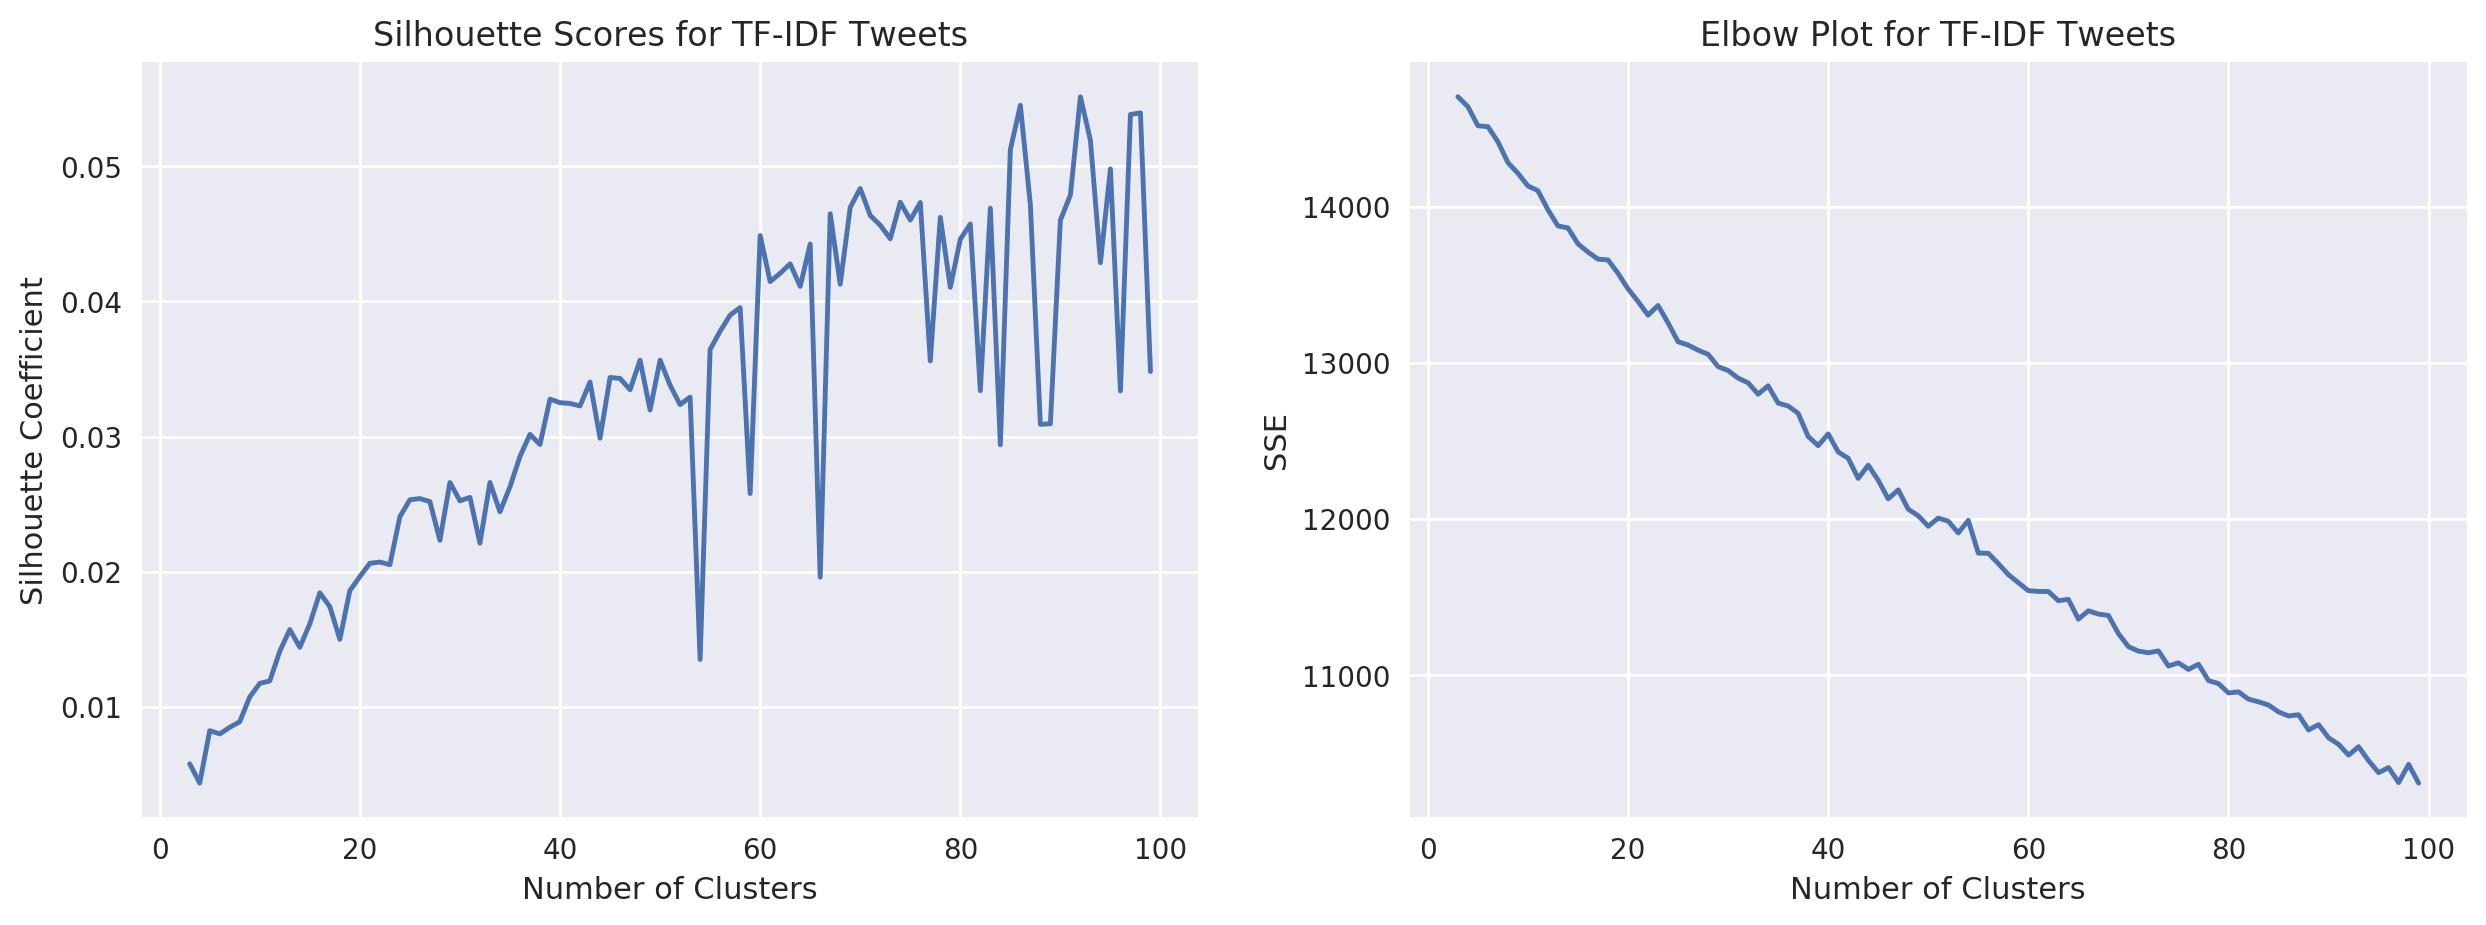

In [11]:
k_clusters = list(k_range)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_title('Silhouette Scores for TF-IDF Tweets')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_title('Elbow Plot for TF-IDF Tweets')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('SSE');

In [ ]:
clustered_tweets[clustered_tweets['cluster_k49'] == 30]['text'].sample(5).values


In [ ]:
#1 Hillary slander
#20: trump +
#0 Hillary
#13 Trump Hillary
#28 Obama
# 